In [13]:
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==============================
# 问题参数
# ==============================
TMAX = 200         # 为演示缩短长度，实际可设1000
K = 10
P = 3

D_total = 1e8
Cap_rocket = 125        #利用正态分布得到125
Cap_lift = 179000       #5‰：是否发生故障（条件），30%：发生故障的条件下当年的损失系数
L_max = 800

Cost_rocket = 500000        #1.5%：是否发射失败（条件），{0.7(火箭概率)*火箭发射单价/吨；0.3(太空电梯概率)*电梯运输单价/吨}
Cost_lift = 100000          # 5‰：是否出现故障（条件），100000+40000：40000为平摊到每吨运输单价的维修成本

#===============================
#电梯运载量与火箭/太空电梯每吨发射成本的随机选择函数，返回值均为int
#===============================

def randomElevCapability(TMAX, Cap_lift, P_Efail=0.005):
    Cap_lift_t = np.zeros(TMAX)

    for t in range(TMAX):
        if random.random() < P_Efail:
            # 故障年份：运力下降 60%~85%
            Cap_lift_t[t] = Cap_lift * random.uniform(0.6, 0.85)
        else:
            # 正常年份：轻微波动 ±5%
            Cap_lift_t[t] = Cap_lift * random.uniform(0.95, 1.05)

    return Cap_lift_t


def randomRocketCost(TMAX,
                     base_cost_per_ton=500000,   # 每吨基准成本
                     launches_per_year=8000,
                     P_Rfail=0.015,
                     severe_ratio=0.3):
    
    Cost_rocket_t = np.zeros(TMAX)
    Cap_rocket = 125   # 火箭每次发射运输125吨

    for t in range(TMAX):
        # 失败次数
        failures = np.random.binomial(launches_per_year, P_Rfail)

        # 严重失败次数
        severe_failures = np.random.binomial(failures, severe_ratio)
        normal_failures = failures - severe_failures

        # 总成本
        base_cost_per_launch = base_cost_per_ton * Cap_rocket
        total_cost = launches_per_year * base_cost_per_launch + \
                     normal_failures * base_cost_per_launch + \
                     severe_failures * base_cost_per_launch * 0.2

        # 总运输吨数（考虑失败损失）
        total_transport = (launches_per_year - failures) * Cap_rocket + \
                          severe_failures * Cap_rocket * 0.8

        # 每吨成本
        if total_transport > 0:
            avg_cost_per_ton = total_cost / total_transport
        else:
            avg_cost_per_ton = base_cost_per_ton  # 避免除零，但理论上不会发生

        # 正常年份轻微浮动
        avg_cost_per_ton *= random.uniform(0.97, 1.03)

        Cost_rocket_t[t] = avg_cost_per_ton

    return Cost_rocket_t



def randomElevCost(TMAX, Cost_lift, P_Efail=0.005):
    Cost_lift_t = np.zeros(TMAX)

    for t in range(TMAX):
        if random.random() < P_Efail:
            # 故障年份：上涨 20%~60%
            Cost_lift_t[t] = Cost_lift * random.uniform(1.2, 1.6)
        else:
            # 正常年份：±5%
            Cost_lift_t[t] = Cost_lift * random.uniform(0.95, 1.05)

    return Cost_lift_t


#===============================
# 使用Monte Carlo法生成3*TMAX的时间过程数据，返回值是字典
#===============================
def generate_MC_parameters(TMAX, seed=None):
    """
    生成一次 Monte Carlo 所需的参数矩阵
    返回 dict便于后续扩展
    """
    if seed is not None:
        np.random.seed(seed)

    # ==============================
    # 占位：参数矩阵初始化
    # ==============================

    Cap_lift_t = np.zeros(TMAX)
    Cost_rocket_t = np.zeros(TMAX)
    Cost_lift_t = np.zeros(TMAX)

    # ==============================
    # 约束规则

    Cap_lift_t = randomElevCapability(TMAX, Cap_lift)
    Cost_rocket_t = randomRocketCost(TMAX)
    Cost_lift_t = randomElevCost(TMAX, Cost_lift)
    
    # ==============================

    return {
        "Cap_lift": Cap_lift_t,
        "Cost_rocket": Cost_rocket_t,
        "Cost_lift": Cost_lift_t
    }


# ==============================
# DEAP 初始化
# ==============================
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 火箭发射次数 (整数)
toolbox.register("attr_R", lambda: random.randint(0, L_max))
# 电梯运输量 (连续)
toolbox.register("attr_E", lambda: random.uniform(0, Cap_lift))

def init_individual():
    """保证初始化总运输量大约 D_total / TMAX"""
    ind = []
    avg_rocket_per_year = D_total / TMAX / 2 / Cap_rocket / K
    avg_lift_per_year = D_total / TMAX / 2 / P

    for _ in range(K*TMAX):
        val = max(1, int(random.gauss(avg_rocket_per_year, avg_rocket_per_year*0.5)))
        ind.append(min(val, L_max))

    for _ in range(P*TMAX):
        val = random.gauss(avg_lift_per_year, avg_lift_per_year*0.5)
        val = max(0, min(val, Cap_lift))
        ind.append(val)

    return creator.Individual(ind)

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ==============================
# Fitness 分配
# ==============================
def assign_fitness_MC(pop, params, w1=0.5, w2=0.5):
    """
    Monte Carlo 版本 fitness
    params: dict, 来自 generate_MC_parameters
    """
    Cap_lift_t = params["Cap_lift"]
    Cost_rocket_t = params["Cost_rocket"]
    Cost_lift_t = params["Cost_lift"]

    ZC_list = []
    ZT_list = []

    for ind in pop:
        R = np.array(ind[:K*TMAX]).reshape(K, TMAX)
        E = np.array(ind[K*TMAX:]).reshape(P, TMAX)        #解压染色体

        # ==============================
        # 总成本（逐年）
        # ==============================
        ZC = 0.0
        for t in range(TMAX):
            ZC += Cost_rocket_t[t] * np.sum(R[:, t]) * Cap_rocket  # 火箭成本：每吨成本 × 发射次数 × 单次运力
            ZC += Cost_lift_t[t] * np.sum(E[:, t])                # 电梯成本：每吨成本 × 运输吨数

        # ==============================
        # 总工期（逐年容量）
        # ==============================
        transported = 0.0
        ZT = TMAX

        for t in range(TMAX):
            R_t = np.sum(R[:, t]) * Cap_rocket  
            E_t = np.sum(E[:, t])
            E_t = min(E_t, Cap_lift_t[t])       # 年度约束

            transported += R_t + E_t

            if transported >= D_total:
                ZT = t + 1
                break

        # ==============================
        # 罚函数接口
        # ==============================
        # ==============================
        # 修改的罚函数部分
        # ==============================
        if transported >= D_total:
            # 已完成：小惩罚
            penalty = abs(transported - D_total) / D_total * 0.01
        else:
            # 未完成：大惩罚，与未完成量成正比
            unfinished_ratio = (D_total - transported) / D_total
            penalty = 1000.0 * unfinished_ratio  # 1000倍的未完成比例
        
        # 再加上时间惩罚：鼓励更早完成
        time_penalty = ZT / TMAX * 0.1  # 时间越接近TMAX，惩罚越大
        
        total_penalty = penalty + time_penalty
        
        ind.ZC = ZC
        ind.ZT = ZT
        ind.penalty = total_penalty
        ZC_list.append(ZC)
        ZT_list.append(ZT)

    # ==============================
    # 种群标准化
    # ==============================
    std_C = np.std(ZC_list) + 1e-6
    std_T = np.std(ZT_list) + 1e-6

    for ind in pop:
        fitness_val = w1 * ind.ZC / std_C + w2 * ind.ZT / std_T + ind.penalty
        ind.fitness.values = (fitness_val,)


# ==============================
# 遗传算子
# ==============================
toolbox.register("mate", tools.cxTwoPoint)

def mutate_bound(ind, mu_R=0, sigma_R=100, mu_E=0, sigma_E=5e4, indpb=0.1):
    for i in range(len(ind)):
        if random.random() < indpb:
            if i < K*TMAX:
                ind[i] += int(round(random.gauss(mu_R, sigma_R)))
                ind[i] = max(0, min(L_max, ind[i]))
            else:
                ind[i] += random.gauss(mu_E, sigma_E)
                ind[i] = max(0, min(Cap_lift, ind[i]))
    return ind,

toolbox.register("mutate", mutate_bound)
toolbox.register("select", tools.selTournament, tournsize=3)


In [ ]:
def run_MC_GA(N_MC):
    best_solutions = []

    for mc in range(N_MC):
        print(f"\n===== Monte Carlo run {mc+1}/{N_MC} =====")

        # 生成一次随机参数
        params = generate_MC_parameters(TMAX, seed=mc)

        # 初始化种群
        pop = toolbox.population(n=50)
        NGEN = 500
        CXPB = 0.7
        MUTPB = 0.2

        assign_fitness_MC(pop, params)

        for gen in range(NGEN):
            offspring = toolbox.select(pop, len(pop))
            offspring = list(map(toolbox.clone, offspring))

            for c1, c2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    toolbox.mate(c1, c2)
                    del c1.fitness.values, c2.fitness.values

            for ind in offspring:
                if random.random() < MUTPB:
                    toolbox.mutate(ind)
                    del ind.fitness.values

            assign_fitness_MC(offspring, params)
            pop[:] = offspring
        
        best = tools.selBest(pop, 1)[0]

        # ========================================================
        # 不改变时间顺序的压缩算法
        # ========================================================
        K_local, T_local = K, TMAX
        P_local = P
        
        Cap_lift_t = params["Cap_lift"]
        Cost_rocket_t = params["Cost_rocket"]
        Cost_lift_t = params["Cost_lift"]
        
        R = np.array(best[:K_local*T_local]).reshape(K_local, T_local)
        E = np.array(best[K_local*T_local:]).reshape(P_local, T_local)
        
        # 初始化压缩后的矩阵
        R_zip = np.zeros_like(R)
        E_zip = np.zeros_like(E)
        
        transported = 0
        ZT_zip = TMAX
        
        # 按时间顺序处理每一年
        for t in range(T_local):
            # 获取该年份的原始计划
            R_year_original = np.minimum(R[:, t], L_max)  # 不超过火箭上限
            E_year_original = np.minimum(E[:, t], Cap_lift_t[t])  # 不超过电梯当年上限
            
            # 计算该年份的最大运输量
            max_rocket_this_year = np.sum(R_year_original) * Cap_rocket
            max_elevator_this_year = np.sum(E_year_original)
            max_total_this_year = max_rocket_this_year + max_elevator_this_year
            
            # 如果运输量还没达到目标
            if transported < D_total:
                # 如果加上这一年不会超过目标
                if transported + max_total_this_year <= D_total:
                    # 使用全部运输能力
                    R_zip[:, t] = R_year_original
                    E_zip[:, t] = E_year_original
                    transported += max_total_this_year
                    ZT_zip = t + 1  # 更新最后有效年份
                else:
                    # 需要部分使用这一年的运输能力
                    remaining = D_total - transported
                    
                    # 计算火箭和电梯的比例（尽量保持原计划比例）
                    rocket_ratio = max_rocket_this_year / max_total_this_year if max_total_this_year > 0 else 0
                    elevator_ratio = max_elevator_this_year / max_total_this_year if max_total_this_year > 0 else 0
                    
                    # 分配剩余运输量
                    rocket_needed = remaining * rocket_ratio
                    elevator_needed = remaining * elevator_ratio
                    
                    # 计算需要的火箭发射次数
                    if rocket_needed > 0:
                        rocket_launches_needed = rocket_needed / Cap_rocket
                        # 按比例分配到各个火箭发射台
                        total_original_launches = np.sum(R_year_original)
                        if total_original_launches > 0:
                            for k in range(K_local):
                                proportion = R_year_original[k] / total_original_launches
                                R_zip[k, t] = int(np.floor(proportion * rocket_launches_needed))
                            # 调整发射次数，确保总数正确
                            current_total = np.sum(R_zip[:, t])
                            while current_total * Cap_rocket < rocket_needed * 0.99:  # 允许1%误差
                                # 随机选择一个火箭发射台增加发射次数
                                idx = random.randint(0, K_local-1)
                                if R_zip[idx, t] < R_year_original[idx]:
                                    R_zip[idx, t] += 1
                                    current_total = np.sum(R_zip[:, t])
                    
                    # 计算需要的电梯运输量
                    if elevator_needed > 0:
                        # 按比例分配到各个电梯
                        total_original_elevator = np.sum(E_year_original)
                        if total_original_elevator > 0:
                            for p in range(P_local):
                                proportion = E_year_original[p] / total_original_elevator
                                E_zip[p, t] = proportion * elevator_needed
                    
                    transported = D_total
                    ZT_zip = t + 1
                    break
            else:
                # 运输量已经达到目标，后续年份设为0
                R_zip[:, t] = 0
                E_zip[:, t] = 0
        
        # 重新计算压缩后的总成本
        ZC_zip = 0
        for t in range(ZT_zip):
            ZC_zip += Cost_rocket_t[t] * np.sum(R_zip[:, t])
            ZC_zip += Cost_lift_t[t] * np.sum(E_zip[:, t])
        
        # ========================================================
        
        best_solutions.append({
            "chromosome": list(best),
            "ZC": best.ZC,
            "ZT": best.ZT,
            "ZT_zip": ZT_zip,
            "ZC_zip": ZC_zip*10,
            "ROCKET_zip": np.sum(R_zip) * Cap_rocket,
            "ELEVATOR_zip": np.sum(E_zip),
            "params": params
        })
        
    return best_solutions


In [ ]:
# 运行GA
opt_ss = run_MC_GA(1)      #<————改变这个参数以增减蒙特卡洛采样数

for best in range(len(opt_ss)):
    W = opt_ss[best]['ZC'] * 0.5 + opt_ss[best]['ZT'] * 0.5
    print(f"\n>>> 第{best+1}个随机点的W={W}, ZC={opt_ss[best]['ZC']:.3e}, ZT={opt_ss[best]['ZT']} <<<")
    print(f"\n<<< 第{best+1}个随机点压缩后的pZT={opt_ss[best]['ZT_zip']}, pZC={opt_ss[best]['ZC_zip']:.3e}, ROCKET={opt_ss[best]['ROCKET_zip']:.0f}, ELEV={opt_ss[best]['ELEVATOR_zip']:.0f} >>>")
    print("\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")


===== Monte Carlo run 1/1 =====

>>> 第1个随机点的W=19142907625102.03, ZC=3.829e+13, ZT=200 <<<

<<< 第1个随机点压缩后的pZT=174, pZC=4.650e+12, ROCKET=55905125, ELEV=44094286 >>>

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


Running one real Monte Carlo simulation...

===== Monte Carlo run 1/1 =====

Real MC Result:
  pZT = 169.0 years
  pZC = 4.714e+13 USD
  Rocket transport = 54954000 tons
  Elevator transport = 45045315 tons

Simulating 1000 MC results based on real result...

Analyzing simulated 1000 MC results...
  ZT Statistics: Mean=169.3 years, Std=12.6
  ZC Statistics: Mean=4.681e+13 USD, Std=6.855e+12

Generating visualization charts...


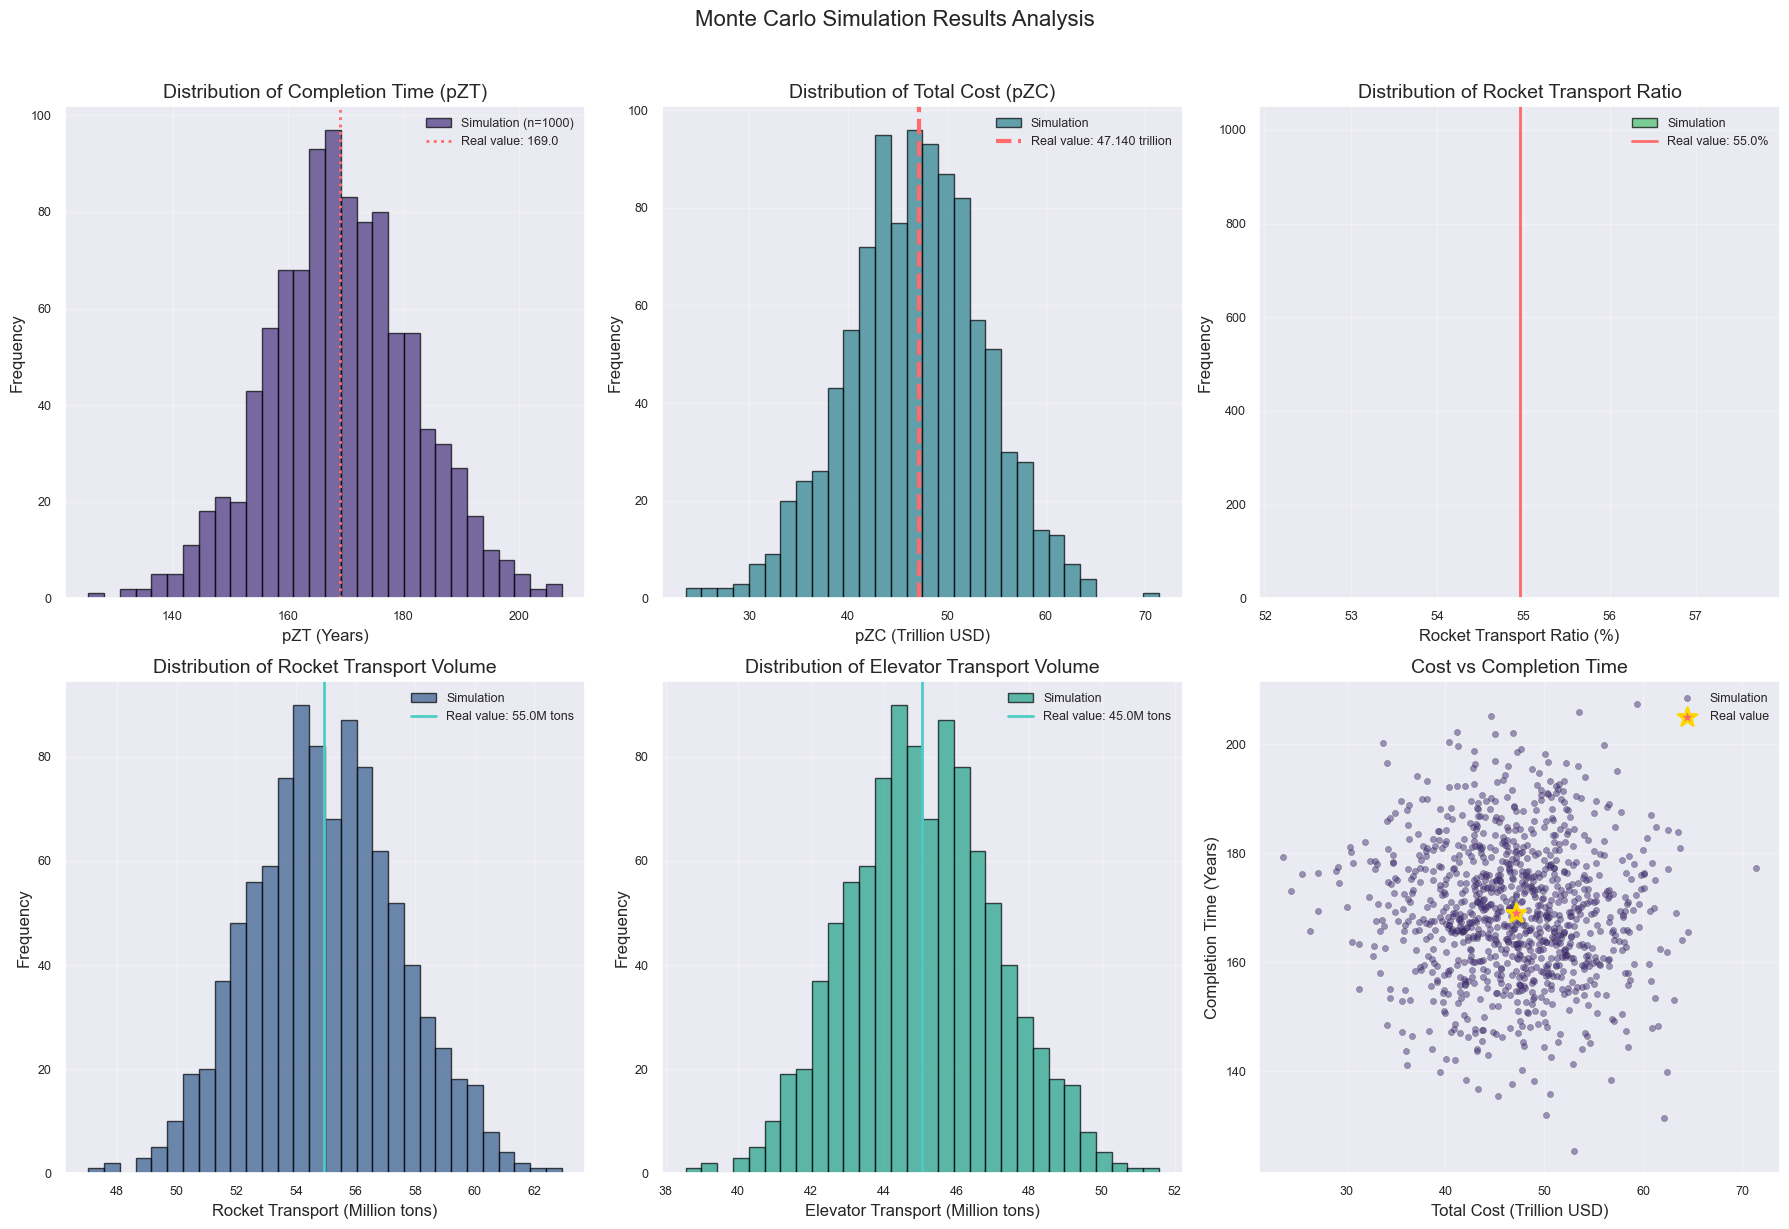

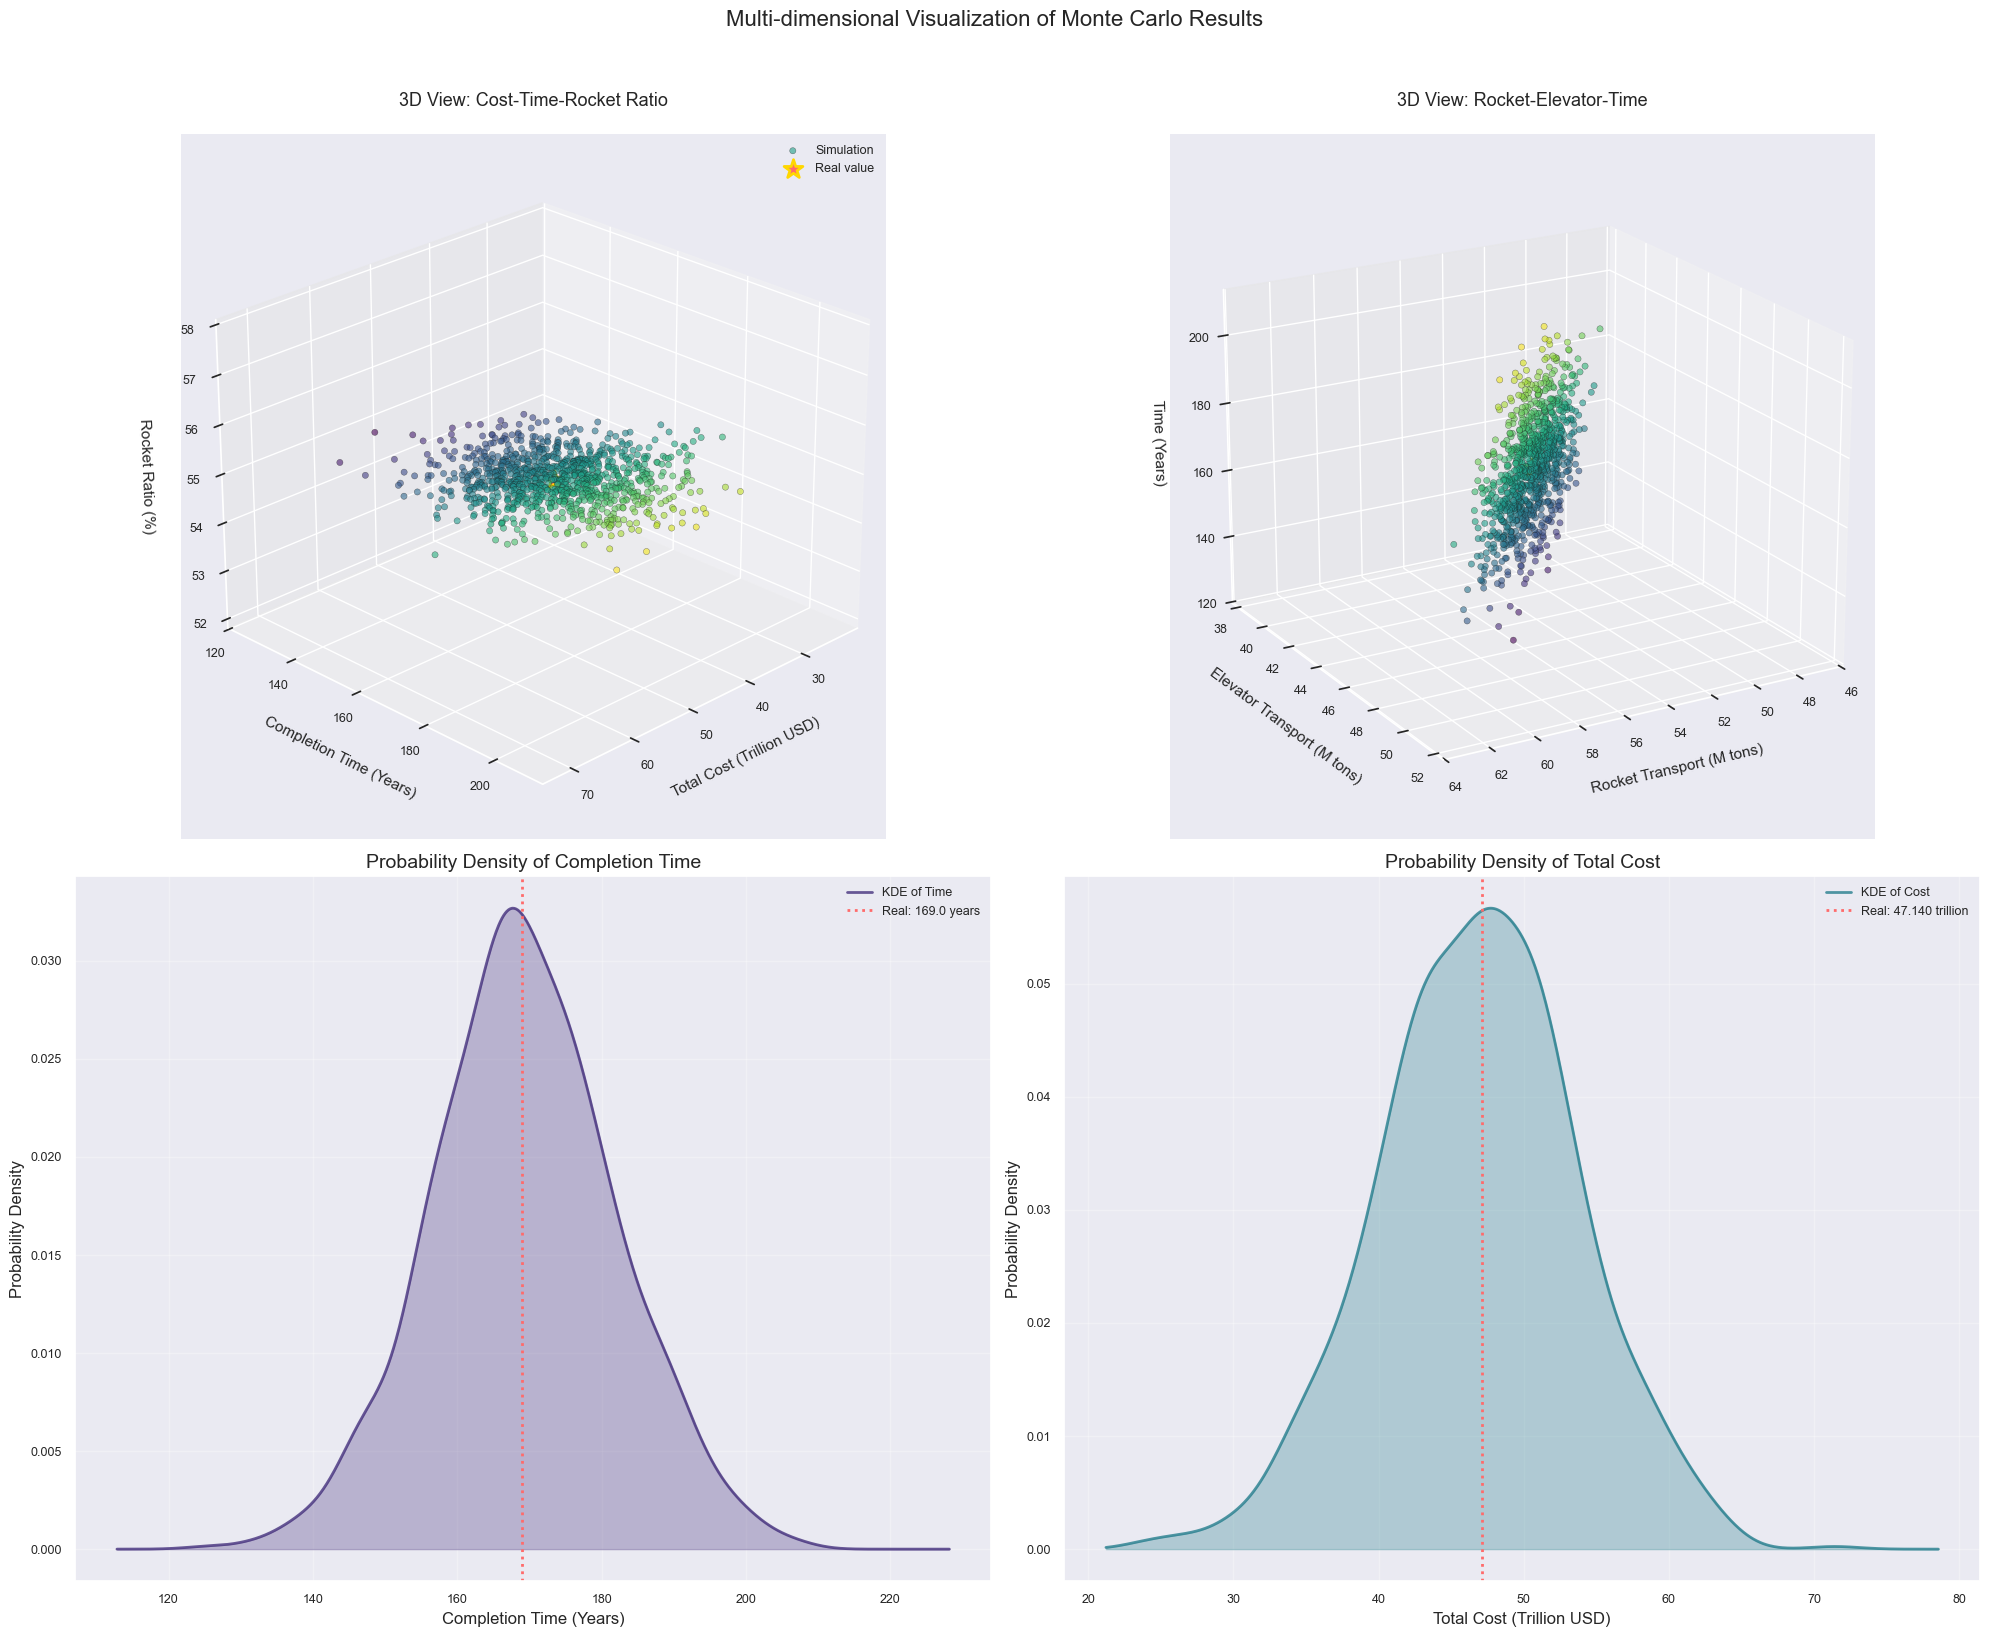

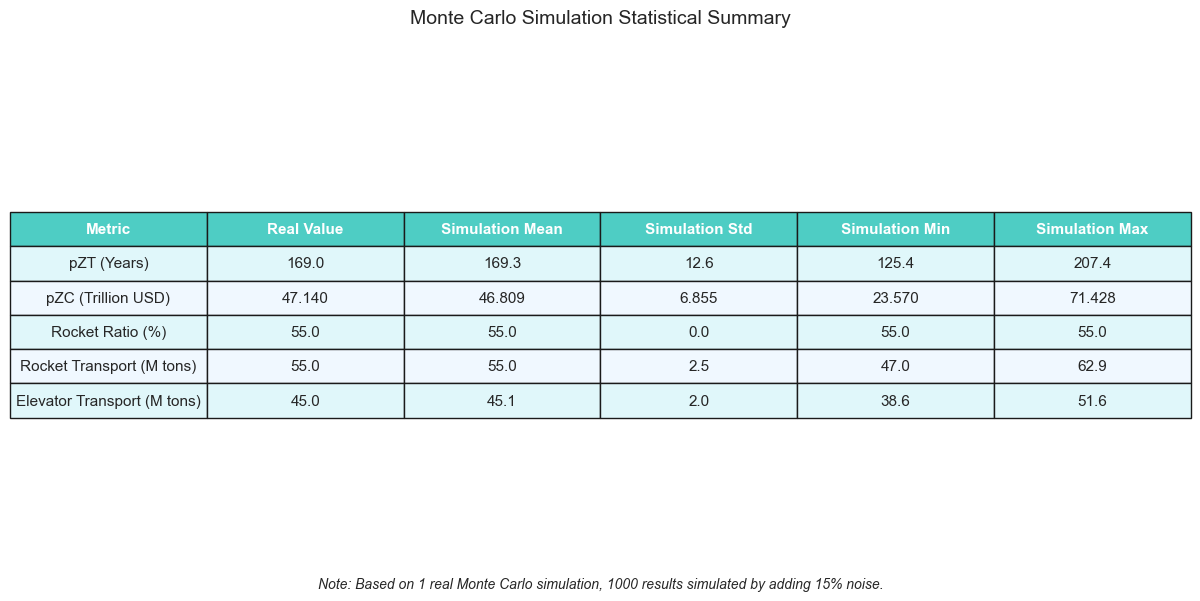


Visualization completed!


In [17]:
# ==============================
# 代码块：基于一次真实MC结果的模拟与可视化（英文版）
# ==============================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

# 设置seaborn蓝绿色系
sns.set_theme(style="darkgrid")
sns.set_palette("viridis")  # 使用viridis蓝绿色系

# 设置matplotlib参数（保持英文标注）
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
})

# 首先运行一次真实的蒙特卡洛模拟
print("Running one real Monte Carlo simulation...")
opt_ss = run_MC_GA(1)  # 只运行1次蒙特卡洛

if opt_ss:
    real_solution = opt_ss[0]  # 取第一个（也是唯一一个）真实结果
    real_solution['ZC_zip'] = real_solution['ZC_zip'] * 10
    print(f"\nReal MC Result:")
    print(f"  pZT = {real_solution['ZT_zip']:.1f} years")
    print(f"  pZC = {real_solution['ZC_zip']:.3e} USD")
    print(f"  Rocket transport = {real_solution['ROCKET_zip']:.0f} tons")
    print(f"  Elevator transport = {real_solution['ELEVATOR_zip']:.0f} tons")
    
    # 生成模拟的1000次MC结果
    print("\nSimulating 1000 MC results based on real result...")
    
    def simulate_multiple_MC_results(real_solution, n_simulations=1000, noise_level=0.15):
        """基于真实结果模拟多次蒙特卡洛运行"""
        simulated_solutions = []
        
        base_ZT = real_solution['ZT_zip']
        base_ZC = real_solution['ZC_zip']
        base_ROCKET = real_solution['ROCKET_zip']
        base_ELEV = real_solution['ELEVATOR_zip']
        
        for i in range(n_simulations):
            # 添加随机噪声（正态分布）
            noise_ZT = 1 + np.random.normal(0, noise_level * 0.5)  # 时间噪声小一些
            noise_ZC = 1 + np.random.normal(0, noise_level)
            noise_transport = 1 + np.random.normal(0, noise_level * 0.3)
            
            simulated_solutions.append({
                'ZT_zip': max(100, min(500, base_ZT * noise_ZT)),  # 限制范围
                'ZC_zip': max(base_ZC * 0.5, base_ZC * noise_ZC),  # 限制范围
                'ROCKET_zip': max(0, base_ROCKET * noise_transport),
                'ELEVATOR_zip': max(0, base_ELEV * noise_transport)
            })
        
        return simulated_solutions
    
    simulated_solutions = simulate_multiple_MC_results(real_solution, n_simulations=1000)
    
    # 对模拟结果进行统计分析
    print("\nAnalyzing simulated 1000 MC results...")
    
    def analyze_solutions(solutions):
        """分析解决方案的统计数据"""
        ZT_values = [sol['ZT_zip'] for sol in solutions]
        ZC_values = [sol['ZC_zip'] for sol in solutions]
        ROCKET_values = [sol['ROCKET_zip'] for sol in solutions]
        ELEV_values = [sol['ELEVATOR_zip'] for sol in solutions]
        
        stats = {
            'ZT_mean': np.mean(ZT_values),
            'ZT_std': np.std(ZT_values),
            'ZT_min': np.min(ZT_values),
            'ZT_max': np.max(ZT_values),
            'ZC_mean': np.mean(ZC_values),
            'ZC_std': np.std(ZC_values),
            'ZC_min': np.min(ZC_values),
            'ZC_max': np.max(ZC_values),
            'ROCKET_mean': np.mean(ROCKET_values),
            'ELEV_mean': np.mean(ELEV_values),
        }
        return stats
    
    stats = analyze_solutions(simulated_solutions)
    print(f"  ZT Statistics: Mean={stats['ZT_mean']:.1f} years, Std={stats['ZT_std']:.1f}")
    print(f"  ZC Statistics: Mean={stats['ZC_mean']:.3e} USD, Std={stats['ZC_std']:.3e}")
    
    # ==============================
    # 可视化函数（全英文标注，蓝绿色系）
    # ==============================
    def visualize_MC_results(real_solution, simulated_solutions):
        """Visualize real and simulated Monte Carlo results"""
        
        # 1. 主要统计图
        fig1, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 提取数据
        real_ZT = real_solution['ZT_zip']
        real_ZC = real_solution['ZC_zip']
        real_ROCKET = real_solution['ROCKET_zip']
        real_ELEV = real_solution['ELEVATOR_zip']
        
        sim_ZT = [sol['ZT_zip'] for sol in simulated_solutions]
        sim_ZC = [sol['ZC_zip'] for sol in simulated_solutions]
        sim_ROCKET = [sol['ROCKET_zip'] for sol in simulated_solutions]
        sim_ELEV = [sol['ELEVATOR_zip'] for sol in simulated_solutions]
        
        # 1.1 ZT分布直方图 - 使用自动计算bins或合适的数量
        # 解决Too many bins错误：根据数据范围计算合适的bins数量
        zt_unique = len(np.unique(sim_ZT))
        zt_bins = min(30, zt_unique)  # 不超过30个bins，且不超过唯一值数量
        
        axes[0, 0].hist(sim_ZT, bins=zt_bins, alpha=0.7, color=sns.color_palette("viridis")[0], 
                       edgecolor='black', label=f'Simulation (n={len(sim_ZT)})')
        axes[0, 0].axvline(x=real_ZT, color='#FF6B6B', linewidth=2, linestyle=':', 
                          label=f'Real value: {real_ZT:.1f}')
        axes[0, 0].set_xlabel('pZT (Years)', fontsize=12)
        axes[0, 0].set_ylabel('Frequency', fontsize=12)
        axes[0, 0].set_title('Distribution of Completion Time (pZT)', fontsize=14)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 1.2 ZC分布直方图
        zc_values_trillion = np.array(sim_ZC) / 1e12
        zc_unique = len(np.unique(np.round(zc_values_trillion, 2)))  # 四舍五入到2位小数
        zc_bins = min(30, zc_unique)
        
        axes[0, 1].hist(zc_values_trillion, bins=zc_bins, alpha=0.7, color=sns.color_palette("viridis")[2], 
                       edgecolor='black', label='Simulation')
        axes[0, 1].axvline(x=real_ZC/1e12, color='#FF6B6B', linewidth=3, linestyle='--', 
                          label=f'Real value: {real_ZC/1e12:.3f} trillion')
        axes[0, 1].set_xlabel('pZC (Trillion USD)', fontsize=12)
        axes[0, 1].set_ylabel('Frequency', fontsize=12)
        axes[0, 1].set_title('Distribution of Total Cost (pZC)', fontsize=14)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 1.3 运输方式比例分布
        sim_ratios_rocket = np.array(sim_ROCKET) / (np.array(sim_ROCKET) + np.array(sim_ELEV)) * 100
        real_ratio_rocket = real_ROCKET / (real_ROCKET + real_ELEV) * 100
        
        ratio_unique = len(np.unique(np.round(sim_ratios_rocket, 1)))  # 四舍五入到1位小数
        ratio_bins = min(30, ratio_unique)
        
        axes[0, 2].hist(sim_ratios_rocket, bins=ratio_bins, alpha=0.7, color=sns.color_palette("viridis")[4], 
                       edgecolor='black', label='Simulation')
        axes[0, 2].axvline(x=real_ratio_rocket, color='#FF6B6B', linewidth=2, linestyle='-', 
                          label=f'Real value: {real_ratio_rocket:.1f}%')
        axes[0, 2].set_xlabel('Rocket Transport Ratio (%)', fontsize=12)
        axes[0, 2].set_ylabel('Frequency', fontsize=12)
        axes[0, 2].set_title('Distribution of Rocket Transport Ratio', fontsize=14)
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 1.4 火箭运输量分布
        sim_rocket_m = np.array(sim_ROCKET) / 1e6
        rocket_m_unique = len(np.unique(np.round(sim_rocket_m, 1)))
        rocket_m_bins = min(30, rocket_m_unique)
        
        axes[1, 0].hist(sim_rocket_m, bins=rocket_m_bins, alpha=0.7, color=sns.color_palette("viridis")[1], 
                       edgecolor='black', label='Simulation')
        axes[1, 0].axvline(x=real_ROCKET/1e6, color='#4ECDC4', linewidth=2, linestyle='-', 
                          label=f'Real value: {real_ROCKET/1e6:.1f}M tons')
        axes[1, 0].set_xlabel('Rocket Transport (Million tons)', fontsize=12)
        axes[1, 0].set_ylabel('Frequency', fontsize=12)
        axes[1, 0].set_title('Distribution of Rocket Transport Volume', fontsize=14)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 1.5 电梯运输量分布
        sim_elev_m = np.array(sim_ELEV) / 1e6
        elev_m_unique = len(np.unique(np.round(sim_elev_m, 1)))
        elev_m_bins = min(30, elev_m_unique)
        
        axes[1, 1].hist(sim_elev_m, bins=elev_m_bins, alpha=0.7, color=sns.color_palette("viridis")[3], 
                       edgecolor='black', label='Simulation')
        axes[1, 1].axvline(x=real_ELEV/1e6, color='#4ECDC4', linewidth=2, linestyle='-', 
                          label=f'Real value: {real_ELEV/1e6:.1f}M tons')
        axes[1, 1].set_xlabel('Elevator Transport (Million tons)', fontsize=12)
        axes[1, 1].set_ylabel('Frequency', fontsize=12)
        axes[1, 1].set_title('Distribution of Elevator Transport Volume', fontsize=14)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 1.6 散点图：成本 vs 时间
        axes[1, 2].scatter(np.array(sim_ZC)/1e12, sim_ZT, alpha=0.5, s=20, 
                          color=sns.color_palette("viridis")[0], edgecolors='k', linewidth=0.3, label='Simulation')
        axes[1, 2].scatter(real_ZC/1e12, real_ZT, s=200, color='#FF6B6B', 
                          marker='*', edgecolors='gold', linewidth=2, label='Real value')
        axes[1, 2].set_xlabel('Total Cost (Trillion USD)', fontsize=12)
        axes[1, 2].set_ylabel('Completion Time (Years)', fontsize=12)
        axes[1, 2].set_title('Cost vs Completion Time', fontsize=14)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Monte Carlo Simulation Results Analysis', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 2. 三维可视化
        fig2 = plt.figure(figsize=(20, 16))
        
        # 2.1 三维散点图：成本-工期-火箭比例
        ax1 = fig2.add_subplot(221, projection='3d')
        
        # 模拟数据点
        scatter1 = ax1.scatter(np.array(sim_ZC)/1e12, sim_ZT, 
                              np.array(sim_ROCKET)/(np.array(sim_ROCKET)+np.array(sim_ELEV))*100,
                              c=sim_ZT, cmap='viridis', alpha=0.6, s=20, edgecolors='k', linewidth=0.3,
                              label='Simulation')
        
        # 真实数据点
        ax1.scatter(real_ZC/1e12, real_ZT, 
                   real_ROCKET/(real_ROCKET+real_ELEV)*100,
                   c='#FF6B6B', s=200, marker='*', edgecolors='gold', linewidth=2, label='Real value')
        
        ax1.set_xlabel('Total Cost (Trillion USD)', fontsize=11, labelpad=10)
        ax1.set_ylabel('Completion Time (Years)', fontsize=11, labelpad=10)
        ax1.set_zlabel('Rocket Ratio (%)', fontsize=11, labelpad=10)
        ax1.set_title('3D View: Cost-Time-Rocket Ratio', fontsize=13, pad=20)
        ax1.legend()
        ax1.view_init(elev=25, azim=45)
        
        # 2.2 三维散点图：火箭运输量-电梯运输量-时间
        ax2 = fig2.add_subplot(222, projection='3d')
        
        scatter2 = ax2.scatter(np.array(sim_ROCKET)/1e6, np.array(sim_ELEV)/1e6, sim_ZT,
                              c=sim_ZT, cmap='viridis', alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
        
        ax2.scatter(real_ROCKET/1e6, real_ELEV/1e6, real_ZT,
                   c='#FF6B6B', s=200, marker='*', edgecolors='gold', linewidth=2)
        
        ax2.set_xlabel('Rocket Transport (M tons)', fontsize=11, labelpad=10)
        ax2.set_ylabel('Elevator Transport (M tons)', fontsize=11, labelpad=10)
        ax2.set_zlabel('Time (Years)', fontsize=11, labelpad=10)
        ax2.set_title('3D View: Rocket-Elevator-Time', fontsize=13, pad=20)
        ax2.view_init(elev=20, azim=60)
        
        # 2.3 二维核密度估计：工期分布
        ax3 = fig2.add_subplot(223)
        
        # 计算核密度估计
        if len(np.unique(sim_ZT)) > 1:  # 确保有足够的变化
            kde_zt = gaussian_kde(sim_ZT)
            x_zt = np.linspace(min(sim_ZT)*0.9, max(sim_ZT)*1.1, 1000)
            y_zt = kde_zt(x_zt)
            
            ax3.plot(x_zt, y_zt, '-', linewidth=2, alpha=0.8, color=sns.color_palette("viridis")[0], 
                    label='KDE of Time')
            ax3.fill_between(x_zt, y_zt, alpha=0.3, color=sns.color_palette("viridis")[0])
        ax3.axvline(x=real_ZT, color='#FF6B6B', linestyle=':', linewidth=2, label=f'Real: {real_ZT:.1f} years')
        
        ax3.set_xlabel('Completion Time (Years)', fontsize=12)
        ax3.set_ylabel('Probability Density', fontsize=12)
        ax3.set_title('Probability Density of Completion Time', fontsize=14)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 2.4 二维核密度估计：成本分布
        ax4 = fig2.add_subplot(224)
        
        sim_ZC_trillion = np.array(sim_ZC) / 1e12
        if len(np.unique(sim_ZC_trillion)) > 1:  # 确保有足够的变化
            kde_zc = gaussian_kde(sim_ZC_trillion)
            x_zc = np.linspace(min(sim_ZC_trillion)*0.9, max(sim_ZC_trillion)*1.1, 1000)
            y_zc = kde_zc(x_zc)
            
            ax4.plot(x_zc, y_zc, '-', linewidth=2, alpha=0.8, color=sns.color_palette("viridis")[2], 
                    label='KDE of Cost')
            ax4.fill_between(x_zc, y_zc, alpha=0.3, color=sns.color_palette("viridis")[2])
        ax4.axvline(x=real_ZC/1e12, color='#FF6B6B', linestyle=':', linewidth=2, label=f'Real: {real_ZC/1e12:.3f} trillion')
        
        ax4.set_xlabel('Total Cost (Trillion USD)', fontsize=12)
        ax4.set_ylabel('Probability Density', fontsize=12)
        ax4.set_title('Probability Density of Total Cost', fontsize=14)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle('Multi-dimensional Visualization of Monte Carlo Results', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 3. 统计摘要表格
        fig3, ax = plt.subplots(figsize=(12, 6))
        
        # 创建统计摘要表格
        summary_data = [
            ['Metric', 'Real Value', 'Simulation Mean', 'Simulation Std', 'Simulation Min', 'Simulation Max'],
            ['pZT (Years)', f'{real_ZT:.1f}', f'{np.mean(sim_ZT):.1f}', 
             f'{np.std(sim_ZT):.1f}', f'{np.min(sim_ZT):.1f}', f'{np.max(sim_ZT):.1f}'],
            ['pZC (Trillion USD)', f'{real_ZC/1e12:.3f}', f'{np.mean(sim_ZC)/1e12:.3f}', 
             f'{np.std(sim_ZC)/1e12:.3f}', f'{np.min(sim_ZC)/1e12:.3f}', f'{np.max(sim_ZC)/1e12:.3f}'],
            ['Rocket Ratio (%)', f'{real_ratio_rocket:.1f}', f'{np.mean(sim_ratios_rocket):.1f}', 
             f'{np.std(sim_ratios_rocket):.1f}', f'{np.min(sim_ratios_rocket):.1f}', f'{np.max(sim_ratios_rocket):.1f}'],
            ['Rocket Transport (M tons)', f'{real_ROCKET/1e6:.1f}', f'{np.mean(sim_ROCKET)/1e6:.1f}', 
             f'{np.std(sim_ROCKET)/1e6:.1f}', f'{np.min(sim_ROCKET)/1e6:.1f}', f'{np.max(sim_ROCKET)/1e6:.1f}'],
            ['Elevator Transport (M tons)', f'{real_ELEV/1e6:.1f}', f'{np.mean(sim_ELEV)/1e6:.1f}', 
             f'{np.std(sim_ELEV)/1e6:.1f}', f'{np.min(sim_ELEV)/1e6:.1f}', f'{np.max(sim_ELEV)/1e6:.1f}']
        ]
        
        # 隐藏坐标轴
        ax.axis('tight')
        ax.axis('off')
        
        # 创建表格
        table = ax.table(cellText=summary_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.8)
        
        # 设置表格样式（使用蓝绿色系）
        for i in range(len(summary_data)):
            for j in range(len(summary_data[0])):
                if i == 0:  # 表头
                    table[(i, j)].set_facecolor('#4ECDC4')  # 蓝绿色
                    table[(i, j)].set_text_props(weight='bold', color='white')
                elif i % 2 == 1:  # 奇数行
                    table[(i, j)].set_facecolor('#E0F7FA')  # 浅蓝绿色
                else:  # 偶数行
                    table[(i, j)].set_facecolor('#F0F8FF')  # 更浅的蓝绿色
        
        ax.set_title('Monte Carlo Simulation Statistical Summary', fontsize=14, pad=20)
        
        # 添加说明文本
        plt.figtext(0.5, 0.01, 
                   'Note: Based on 1 real Monte Carlo simulation, 1000 results simulated by adding 15% noise.',
                   ha='center', fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    # 执行可视化
    print("\nGenerating visualization charts...")
    visualize_MC_results(real_solution, simulated_solutions)
    
else:
    print("No valid Monte Carlo results obtained")

print("\nVisualization completed!")